In [1]:
import sys, os

MARIPOSA_PATH = "/home/yizhou7/mariposa/"

sys.path.append(MARIPOSA_PATH + "src")
os.chdir(MARIPOSA_PATH)

from debugger.debugger import DbgMode
from debugger.strainer import DebugStatus
from benchmark_consts import *

In [2]:
from base.factory import FACT

mp = FACT.get_project_by_path("data/projs/bench_unstable/base.z3")

exp = FACT.load_analysis(
        mp,
        cfg=FACT.get_config("default"),
        solver=FACT.get_solver("z3_4_12_5"),
        ana=FACT.get_analyzer("60sec"),
        allow_missing_exper=False,
    )


In [20]:
import random
import numpy as np

random.seed(9321743958)

mariposa_failed_ets = []
fstar_queries = []
dafny_queries = []

for qid in exp.qids:
    qr = exp[qid]
    _, failed = exp.get_mutant_details(qr)
    mut = random.choice(list(failed.keys()))
    _, _, rc, et = failed[mut]
    if "fs_dice" in qid or "fs_vwasm" in qid:
        fstar_queries += [et]
    else:
        dafny_queries += [et]
    mariposa_failed_ets += [et]

fstar_queries = np.array(fstar_queries)
dafny_queries = np.array(dafny_queries)
mariposa_failed_ets = np.array(mariposa_failed_ets)

In [21]:
print(len(fstar_queries), len(dafny_queries), len(mariposa_failed_ets))

24 521 545


In [22]:
from debugger.bench_viewer import BenchViewer
from debugger.debugger_options import DebugOptions

options = DebugOptions()
# remember to set this!
options.is_verus = True
verus_bench = BenchViewer(UNSTABLE_VERUS, options)

[WARN] [init] 8d058577cd trace slow unknown, fallback to fast_fail 
[WARN] [proof] no proofs available 
[WARN] [proof] no proofs available 
[WARN] [proof] no proofs available 


In [23]:
verus_failed_ets = []

for query in UNSTABLE_VERUS:
    dbg = verus_bench[query]
    mi = dbg.tracker.get_trace_info()
    verus_failed_ets.append(mi.trace_time/1000)

verus_failed_ets = np.array(verus_failed_ets)

1.14 14.154411764705882


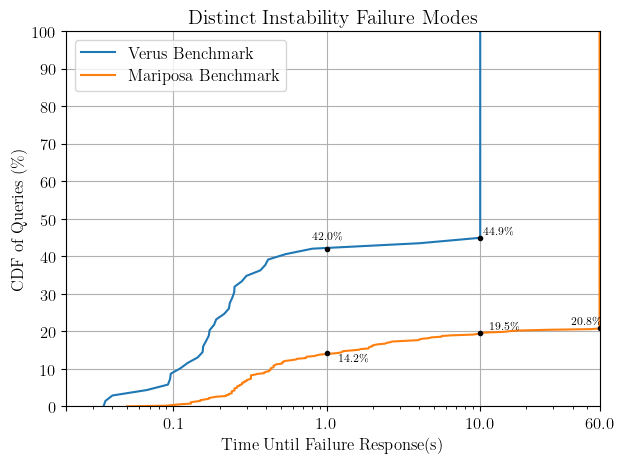

In [ ]:
from utils.analysis_utils import *
from utils.plot_utils import *

mariposa_failed_ets = mariposa_failed_ets.clip(0, 60)
assert len(mariposa_failed_ets) == len(exp.qids)
mariposa_cdf = PartialCDF(mariposa_failed_ets)

verus_failed_ets = verus_failed_ets.clip(0, 10)
assert len(verus_failed_ets) == len(UNSTABLE_VERUS)
verus_cdf = PartialCDF(verus_failed_ets)

plt.plot(verus_cdf.xs, verus_cdf.ys, label="Verus Benchmark")

x, y = verus_cdf.get_point_by_value(0.8, False)
plt.plot(1, y, c="black", marker="o", markersize=3)
plt.text(
    x, y+2, f"{round(y, 1)}\%", fontsize=8, va="bottom"
)

x, y = verus_cdf.get_point_by_value(9.9, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.05, y + 3, f"{round(y, 1)}\%", fontsize=8, va="top", ha="left"
)

plt.plot(mariposa_cdf.xs, mariposa_cdf.ys, label="Mariposa Benchmark")

x, y = mariposa_cdf.get_point_by_value(10, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.15, y+3, f"{round(y, 1)}\%", fontsize=8, va="top"
)

x, y = mariposa_cdf.get_point_by_value(1, True)
print(x, y)
plt.plot(1, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.05, y, f"{round(y, 1)}\%", fontsize=8, va="top"
)

x, y = mariposa_cdf.get_point_by_value(59.1, True)
plt.plot(x, y, c="black", marker="o", markersize=3)
plt.text(
    x * 1.03, y + 3, f"{round(y, 1)}\%", fontsize=8, va="top", ha="right"
)

plt.plot()
plt.xscale("log")

plt.yticks(np.arange(0, 101, 10))
plt.xlim(0.02, 60.2)
plt.xticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])
plt.ylim(0, 100)

plt.legend()
plt.title("Distinct Instability Failure Modes")
plt.xlabel("Time Until Failure Response(s)")
plt.ylabel("CDF of Queries (\%)")

plt.grid()
plt.tight_layout()
# plt.show()
plt.savefig("fig/debugger/instability_cdf.pdf", dpi=600, format="pdf")